In [1]:
%load_ext autoreload
%autoreload 2

import os
# Run everything on CPU, if GPU is available comment out
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import sys
sys.path.append("src/")
import src.preprocessing.data_loading_SL as data_loading_SL
import src.preprocessing.SL_Xstreme as SL_Xstreme
import src.preprocessing.SL_PCA as SL_PCA
import models.experiment as experiment
import models.rnn as rnn
import subprocess
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import analysis.heatmap_analysis_SL as heatmap
from scipy.stats import pearsonr
from scipy.spatial.distance import cdist
from Bio import SeqIO
from collections import Counter
from xml.etree import ElementTree as ET
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from tensorflow import keras
from functools import partial
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    seq_contains_mdm2_motif,
    seq_contains_SL_motif,
    seq_contains_12ca5_motif,
    benchmark_cross_validated_hit_rate,
)
from analysis.scatter_plots import (
    plot_fancy_hexbin_relations
)
from models.rnn import multi_channel_mse

Generating ER datafiles!


In [10]:
protein_of_interest = "SL"
other_protein = "12ca5"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2]) + p-value
    return 1*x[1] + 0*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "SL" else 1000
motif_dectection_func = (
    seq_contains_SL_motif
    if protein_of_interest == "SL"
    
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/SL.h5"
    if protein_of_interest == "SL"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading_SL.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="SL-12ca5-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)
print(len(FEATURE_LIST))
print(FEATURE_LIST)
print(y_raw[0])

print(X.shape)


/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/preprocessing/data_loading_SL.py:51: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  lib = pd.read_csv(os.path.join(HOME_DIRECTORY, "data", datafile))


jointlibShape:  (5547, 31)
Unnamed: 0x                                                      0
Peptide                                                    FDYKDDP
MDM2 sum_x                                                 0.00002
MDM2 sum_y                                                 0.00002
MDM2 sum                                                   0.00002
ER                                                             0.0
Lengthx                                                          7
is_dyax                                                      False
is_llex                                                      False
c_cntx                                                           0
Pro2Vecx         [0.6172555904835056, 0.6321068001250965, 0.595...
RAAx             [1.0, 0.03205128, 0.69871795, 1e-08, 0.0320512...
propx            [[1.19, -9.2, -2.5, 0.038, 5.2, 0.35, 0.29, 2....
onehotx          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Unnamed: 0                         

## Baseline Experimental Rankings

(-9.91044936719671, 9.62783842903401, -4.3968678950507, 69.54242556254869)


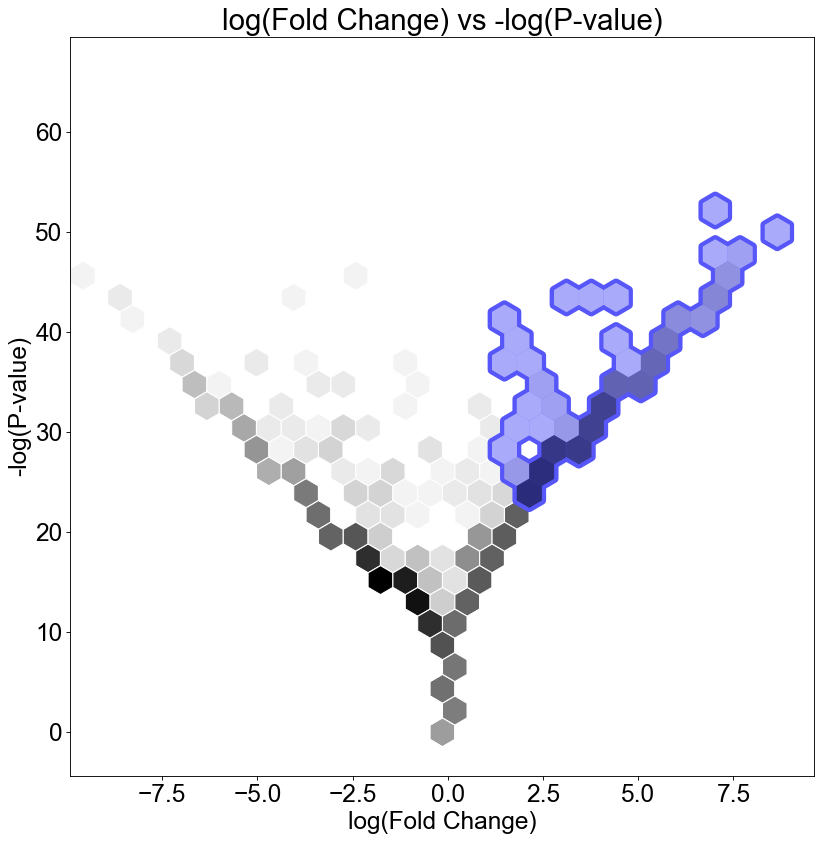

Try  5.018376352920876
5.018376352920876
(-9.91044936719671, 9.62783842903401, -4.3968678950507, 69.54242556254869)


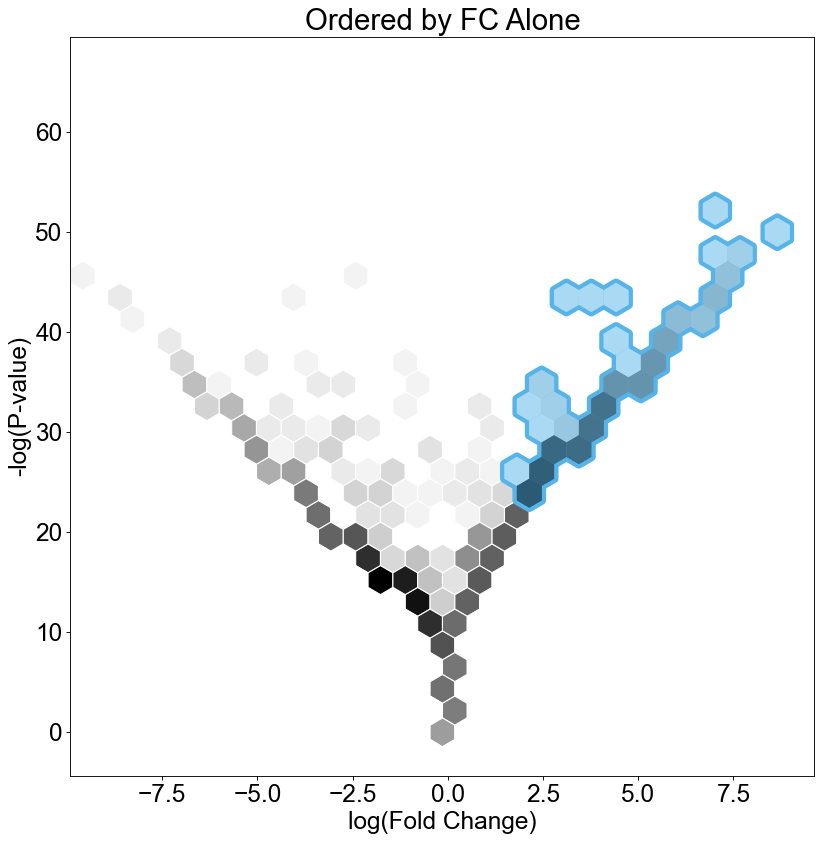

(0.0, 0.0, -9.91044936719671, 9.62783842903401)


/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4861: RuntimeWarning: invalid value encountered in divide
  ix = (tx - xmin) / sx
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4863: RuntimeWarning: invalid value encountered in cast
  ix1 = np.round(ix).astype(int)
/Users/stephen/mambaforge/envs/BiLSTM_new/lib/python3.10/site-packages/matplotlib/axes/_axes.py:4865: RuntimeWarning: invalid value encountered in cast
  ix2 = np.floor(ix).astype(int)
/Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main/src/analysis/scatter_plots.py:142: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(extent[0], extent[1])  # required as second call of plt.hexbin()


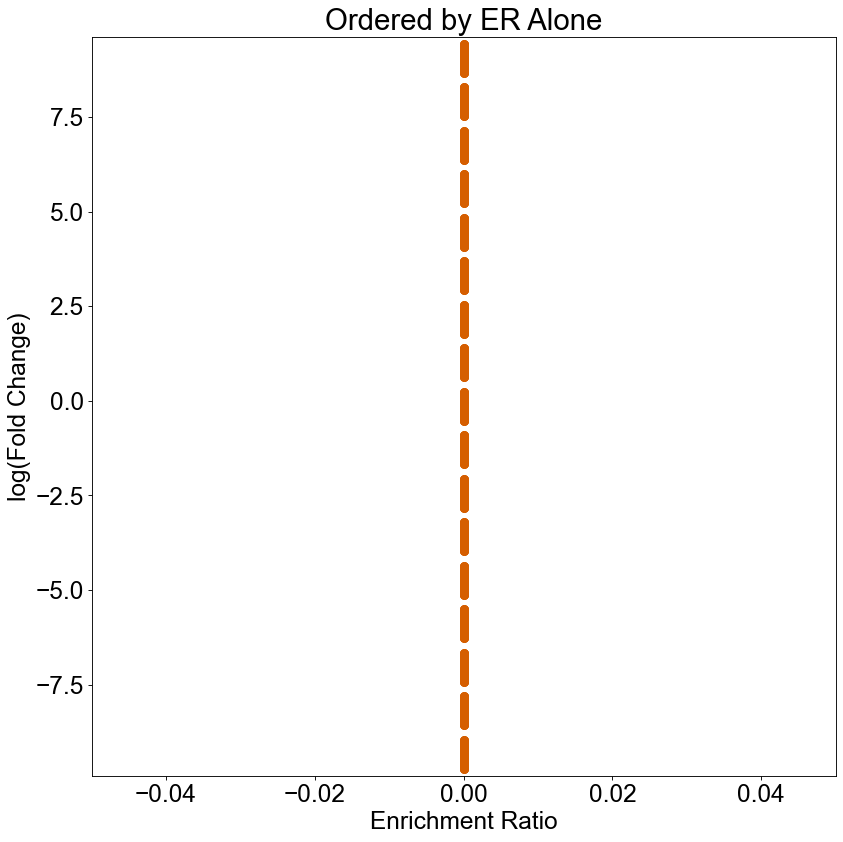

(0.0, 0.0, -9.91044936719671, 9.62783842903401)


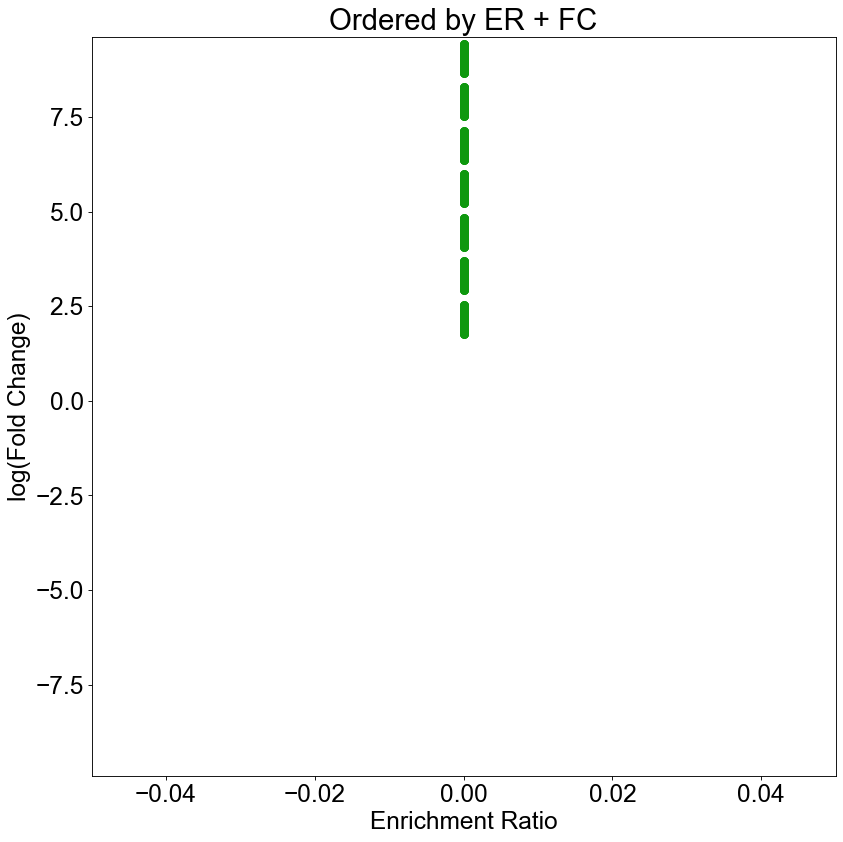

In [11]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "SL"
    else np.array([val[0] * val[1] for val in y_raw])
)

plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=volcano_ordering,
    all_positives=None,
    line_color='#5757F9',
    top_k=top_k_size,
)

fc_alone_SL_ordering = [y[1] for y in y_raw]

print("Try ",y_raw[0][1])
print(fc_alone_SL_ordering[0])
plot_fancy_hexbin_relations(
    1,
    0,
    datapoints=y_raw,
    ordering=fc_alone_SL_ordering,
    all_positives=None,
    line_color='#56B4E9',
    title='Ordered by FC Alone',
    top_k=top_k_size,
)

er_SL_ordering = [y[2] for y in y_raw]


plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_SL_ordering,
    all_positives=None,
    line_color='#D55E00',
    title='Ordered by ER Alone',
    top_k=top_k_size,
)

er_fc_joint_SL_ordering = [1*y[2] + y[1] + 0*y[0] for y in y_raw]

plot_fancy_hexbin_relations(
    2,
    1,
    datapoints=y_raw,
    ordering=er_fc_joint_SL_ordering,
    all_positives=None,
    line_color='#0F980F',
    title='Ordered by ER + FC',
    top_k=top_k_size,
)


YEYKDDP
max is  185.0
YEYKDDP
max is  181.0
YEYKDDP
max is  776.0
YEYKDDP
max is  185.0


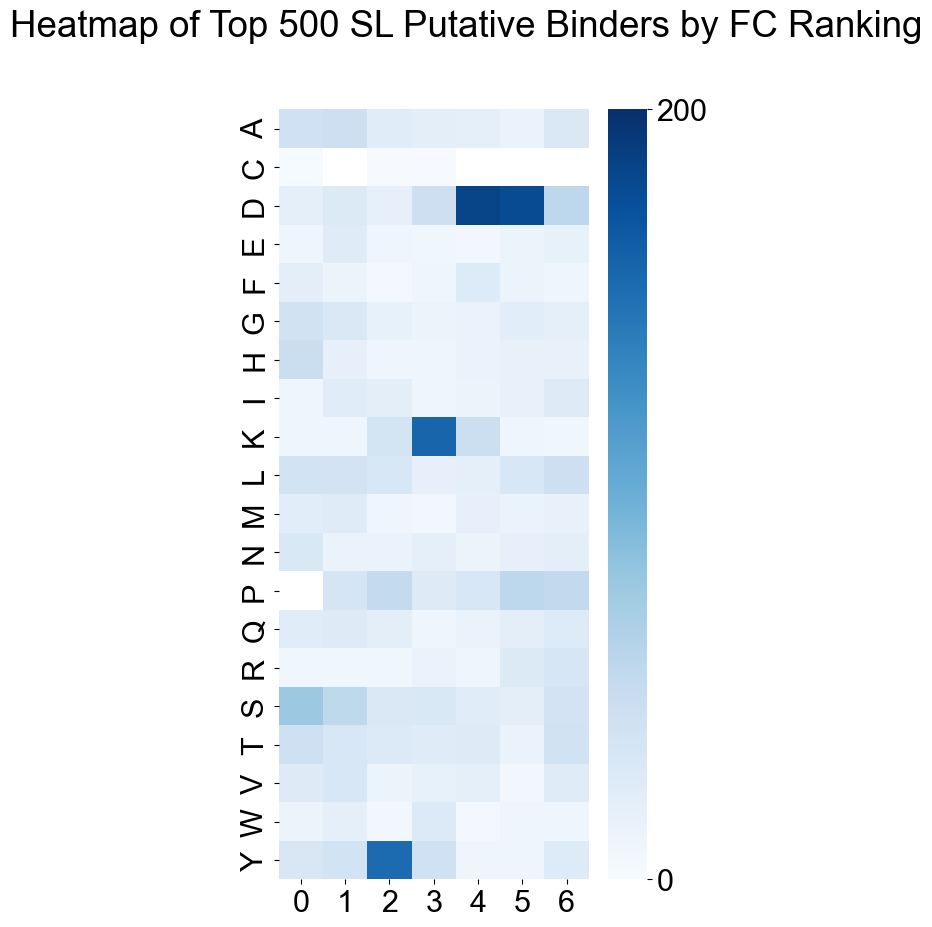

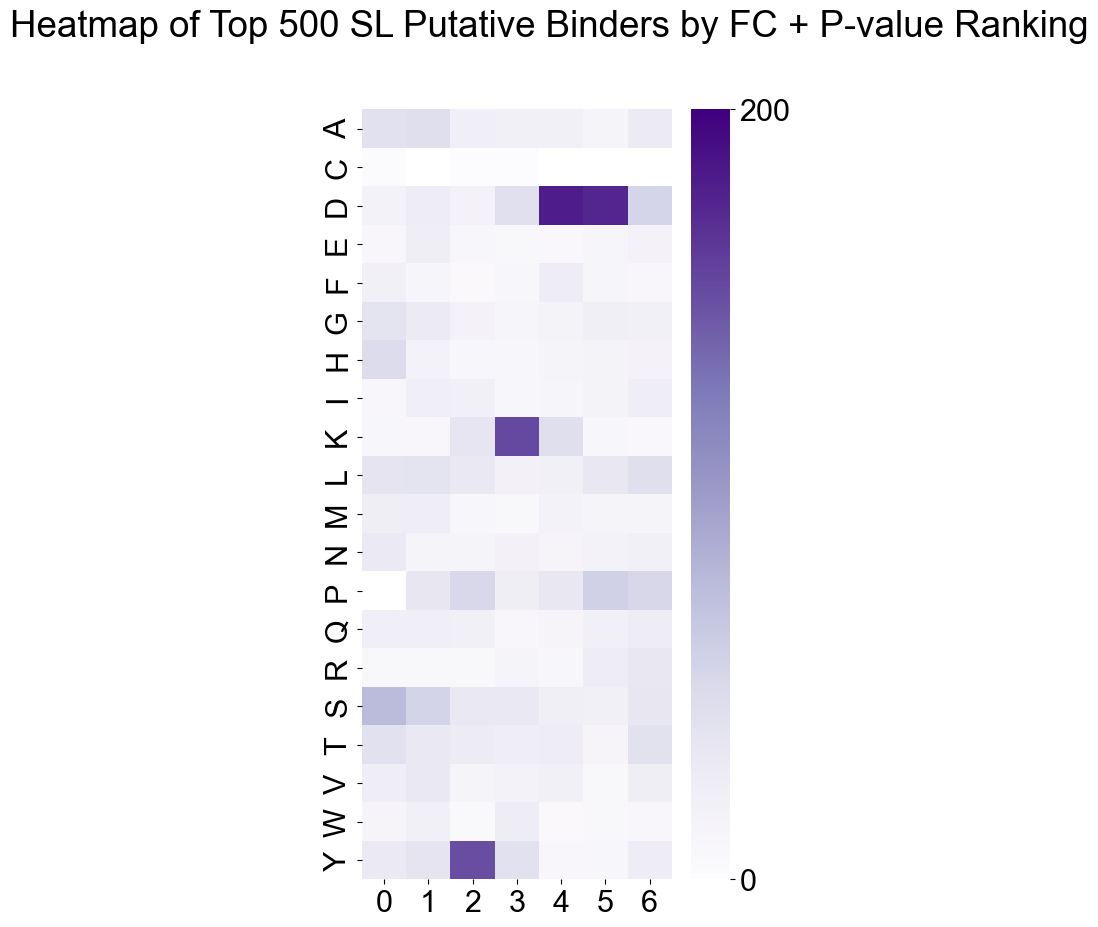

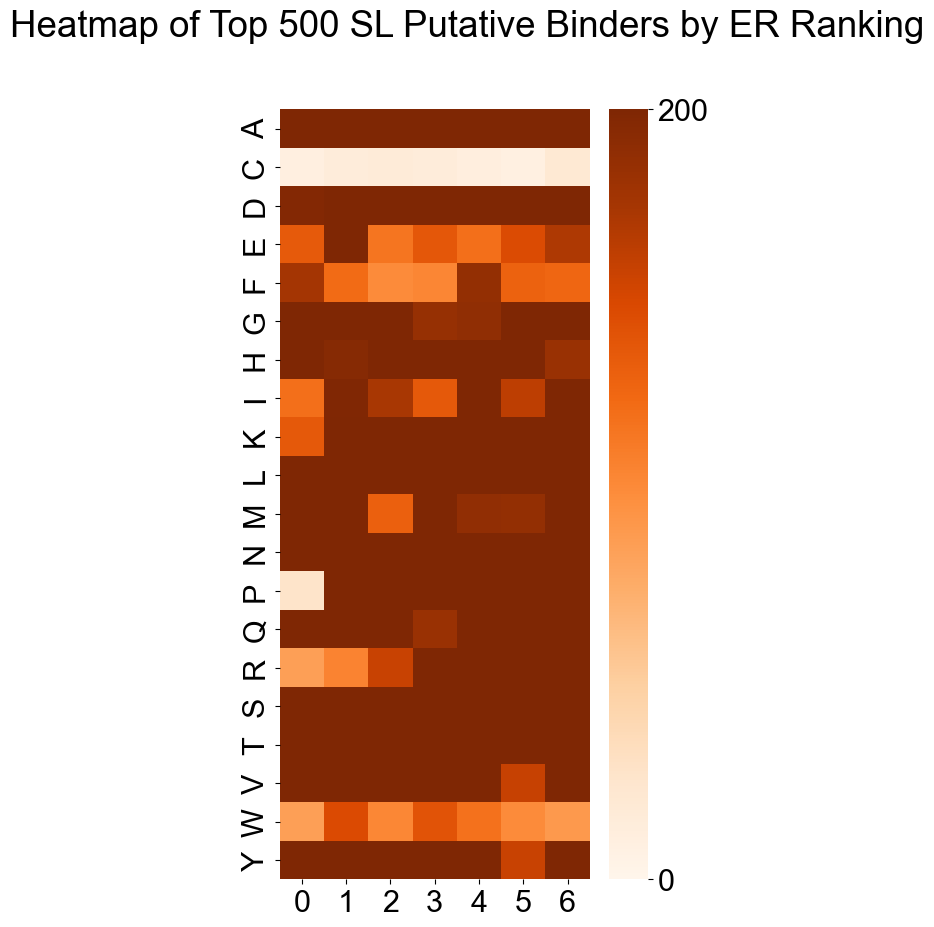

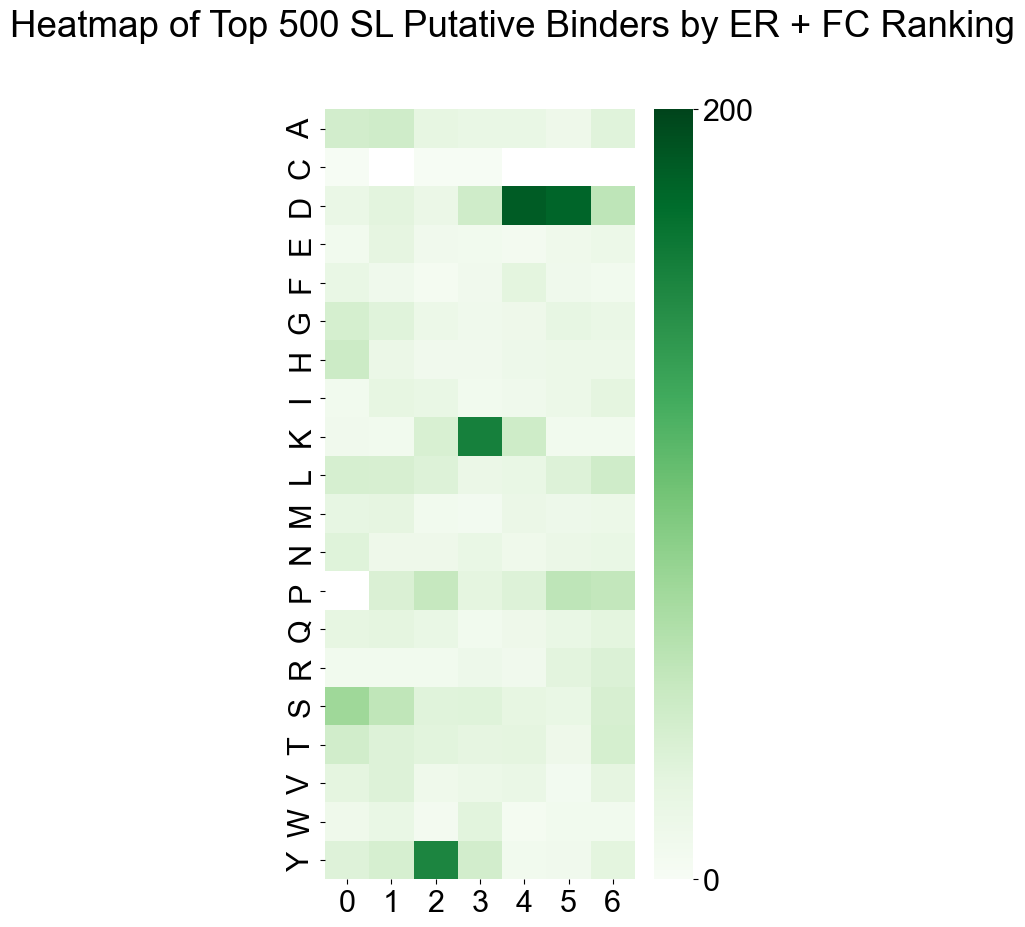

In [12]:
def show_heatmap_for_top_k(title, ordering, color, peptides=peptides, top_k=top_k_size): #top_k_size=500 for MDM2
    top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
    top_k_peptides = [pep for pep, mask in zip(peptides, top_k_mask) if mask]
    print(top_k_peptides[0])

    heatmap.generate_heatmap(
        top_k_peptides, #list of the peptide AA sequence
        title=title, #title
        vmax=200 if protein_of_interest == 'SL' else 600,
        colormap=color,
    )

show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_SL_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_SL_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_SL_ordering, 'Greens')

## BiLSTM Ranking

In [19]:
print(X.shape)
print(len(FEATURE_LIST))
flatX = X.reshape(5547, 259, order='F')
print(flatX.shape)

# Expand feature names by appending _T1 to _T14
expanded_feature_names = [f"{feat}_I{t+1}" for feat in FEATURE_LIST for t in range(7)]
print(expanded_feature_names)

# Convert to DataFrame with correct column names
df_flatX = pd.DataFrame(flatX, columns=expanded_feature_names)

# Display the first few rows
df_flatX.head()


(5547, 7, 37)
37
(5547, 259)
['Pro2Vec_I1', 'Pro2Vec_I2', 'Pro2Vec_I3', 'Pro2Vec_I4', 'Pro2Vec_I5', 'Pro2Vec_I6', 'Pro2Vec_I7', 'RAA_I1', 'RAA_I2', 'RAA_I3', 'RAA_I4', 'RAA_I5', 'RAA_I6', 'RAA_I7', 'H11_I1', 'H11_I2', 'H11_I3', 'H11_I4', 'H11_I5', 'H11_I6', 'H11_I7', 'H12_I1', 'H12_I2', 'H12_I3', 'H12_I4', 'H12_I5', 'H12_I6', 'H12_I7', 'H2_I1', 'H2_I2', 'H2_I3', 'H2_I4', 'H2_I5', 'H2_I6', 'H2_I7', 'NCI_I1', 'NCI_I2', 'NCI_I3', 'NCI_I4', 'NCI_I5', 'NCI_I6', 'NCI_I7', 'P11_I1', 'P11_I2', 'P11_I3', 'P11_I4', 'P11_I5', 'P11_I6', 'P11_I7', 'P12_I1', 'P12_I2', 'P12_I3', 'P12_I4', 'P12_I5', 'P12_I6', 'P12_I7', 'P2_I1', 'P2_I2', 'P2_I3', 'P2_I4', 'P2_I5', 'P2_I6', 'P2_I7', 'SASA_I1', 'SASA_I2', 'SASA_I3', 'SASA_I4', 'SASA_I5', 'SASA_I6', 'SASA_I7', 'V_I1', 'V_I2', 'V_I3', 'V_I4', 'V_I5', 'V_I6', 'V_I7', 'F_I1', 'F_I2', 'F_I3', 'F_I4', 'F_I5', 'F_I6', 'F_I7', 'A1_I1', 'A1_I2', 'A1_I3', 'A1_I4', 'A1_I5', 'A1_I6', 'A1_I7', 'E_I1', 'E_I2', 'E_I3', 'E_I4', 'E_I5', 'E_I6', 'E_I7', 'T_I1', 'T_I2', 'T

,Pro2Vec_I1,Pro2Vec_I2,Pro2Vec_I3,Pro2Vec_I4,Pro2Vec_I5,Pro2Vec_I6,Pro2Vec_I7,RAA_I1,RAA_I2,RAA_I3,...,V_one_hot_I5,V_one_hot_I6,V_one_hot_I7,X_one_hot_I1,X_one_hot_I2,X_one_hot_I3,X_one_hot_I4,X_one_hot_I5,X_one_hot_I6,X_one_hot_I7
0,0.617256,0.629118,0.595345,0.549553,0.621296,0.670681,0.617256,0.698718,0.025641,0.698718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.617256,0.711633,0.631431,0.620439,0.603949,0.617102,0.617256,0.358974,0.192308,0.134615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.617256,0.681881,0.609742,0.584870,0.543357,0.622603,0.617256,0.698718,0.160256,0.358974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.617256,0.677364,0.626574,0.597231,0.608106,0.474589,0.617256,0.480769,0.192308,0.698718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.617256,0.634744,0.585521,0.700793,0.648865,0.645614,0.617256,0.147436,0.698718,0.634615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=False,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


Epoch 1/5


2025-08-06 23:05:27.226758: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


39/39 [==============================] - ETA: 0s - loss: 0.6555 - multi_channel_mse: 0.6555

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


39/39 [==============================] - 9s 228ms/step - loss: 0.6555 - multi_channel_mse: 0.6555 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6374 - multi_channel_mse: 0.6374

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


39/39 [==============================] - 9s 225ms/step - loss: 0.6374 - multi_channel_mse: 0.6374 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6271 - multi_channel_mse: 0.6271

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


39/39 [==============================] - 9s 222ms/step - loss: 0.6271 - multi_channel_mse: 0.6271 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6227 - multi_channel_mse: 0.6227

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.6227 - multi_channel_mse: 0.6227 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6153 - multi_channel_mse: 0.6153

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h50/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6153 - multi_channel_mse: 0.6153 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6617 - multi_channel_mse: 0.6617

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


39/39 [==============================] - 9s 226ms/step - loss: 0.6617 - multi_channel_mse: 0.6617 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6452 - multi_channel_mse: 0.6452

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.6452 - multi_channel_mse: 0.6452 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6337 - multi_channel_mse: 0.6337

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.6337 - multi_channel_mse: 0.6337 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6237 - multi_channel_mse: 0.6237

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6237 - multi_channel_mse: 0.6237 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6207 - multi_channel_mse: 0.6207

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h51/assets


39/39 [==============================] - 9s 222ms/step - loss: 0.6207 - multi_channel_mse: 0.6207 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6604 - multi_channel_mse: 0.6604

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


39/39 [==============================] - 9s 226ms/step - loss: 0.6604 - multi_channel_mse: 0.6604 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6517 - multi_channel_mse: 0.6517

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


39/39 [==============================] - 9s 222ms/step - loss: 0.6517 - multi_channel_mse: 0.6517 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6397 - multi_channel_mse: 0.6397

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6397 - multi_channel_mse: 0.6397 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6316 - multi_channel_mse: 0.6316

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


39/39 [==============================] - 9s 222ms/step - loss: 0.6316 - multi_channel_mse: 0.6316 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6247 - multi_channel_mse: 0.6247

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h52/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.6247 - multi_channel_mse: 0.6247 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6600 - multi_channel_mse: 0.6600

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


39/39 [==============================] - 9s 232ms/step - loss: 0.6600 - multi_channel_mse: 0.6600 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6447 - multi_channel_mse: 0.6447

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


39/39 [==============================] - 8s 220ms/step - loss: 0.6447 - multi_channel_mse: 0.6447 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6365 - multi_channel_mse: 0.6365

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.6365 - multi_channel_mse: 0.6365 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6273 - multi_channel_mse: 0.6273

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


39/39 [==============================] - 9s 223ms/step - loss: 0.6273 - multi_channel_mse: 0.6273 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6262 - multi_channel_mse: 0.6262

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h53/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6262 - multi_channel_mse: 0.6262 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6582 - multi_channel_mse: 0.6582

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


39/39 [==============================] - 9s 227ms/step - loss: 0.6582 - multi_channel_mse: 0.6582 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6426 - multi_channel_mse: 0.6426

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.6426 - multi_channel_mse: 0.6426 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6306 - multi_channel_mse: 0.6306

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6306 - multi_channel_mse: 0.6306 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6212 - multi_channel_mse: 0.6212

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6212 - multi_channel_mse: 0.6212 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6166 - multi_channel_mse: 0.6166

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h54/assets


39/39 [==============================] - 9s 225ms/step - loss: 0.6166 - multi_channel_mse: 0.6166 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6615 - multi_channel_mse: 0.6615

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


39/39 [==============================] - 9s 226ms/step - loss: 0.6615 - multi_channel_mse: 0.6615 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6486 - multi_channel_mse: 0.6486

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


39/39 [==============================] - 9s 223ms/step - loss: 0.6486 - multi_channel_mse: 0.6486 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6387 - multi_channel_mse: 0.6387

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


39/39 [==============================] - 9s 223ms/step - loss: 0.6387 - multi_channel_mse: 0.6387 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6267 - multi_channel_mse: 0.6267

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.6267 - multi_channel_mse: 0.6267 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6203 - multi_channel_mse: 0.6203

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h55/assets


39/39 [==============================] - 9s 224ms/step - loss: 0.6203 - multi_channel_mse: 0.6203 - lr: 5.0000e-04
Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.6620 - multi_channel_mse: 0.6620

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


39/39 [==============================] - 9s 228ms/step - loss: 0.6620 - multi_channel_mse: 0.6620 - lr: 5.0000e-04
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.6378 - multi_channel_mse: 0.6378

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6378 - multi_channel_mse: 0.6378 - lr: 5.0000e-04
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.6269 - multi_channel_mse: 0.6269

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


39/39 [==============================] - 8s 218ms/step - loss: 0.6269 - multi_channel_mse: 0.6269 - lr: 5.0000e-04
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.6156 - multi_channel_mse: 0.6156

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


39/39 [==============================] - 8s 219ms/step - loss: 0.6156 - multi_channel_mse: 0.6156 - lr: 5.0000e-04
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.6136 - multi_channel_mse: 0.6136

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h56/assets


39/39 [==============================] - 8s 221ms/step - loss: 0.6136 - multi_channel_mse: 0.6136 - lr: 5.0000e-04
Epoch 1/5
40/40 [==============================] - ETA: 0s - loss: 0.6700 - multi_channel_mse: 0.6700

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


40/40 [==============================] - 9s 222ms/step - loss: 0.6700 - multi_channel_mse: 0.6700 - lr: 5.0000e-04
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.6534 - multi_channel_mse: 0.6534

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


40/40 [==============================] - 9s 221ms/step - loss: 0.6534 - multi_channel_mse: 0.6534 - lr: 5.0000e-04
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.6405 - multi_channel_mse: 0.6405

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


40/40 [==============================] - 8s 216ms/step - loss: 0.6405 - multi_channel_mse: 0.6405 - lr: 5.0000e-04
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.6300 - multi_channel_mse: 0.6300

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


40/40 [==============================] - 9s 217ms/step - loss: 0.6300 - multi_channel_mse: 0.6300 - lr: 5.0000e-04
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.6208 - multi_channel_mse: 0.6208

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h57/assets


40/40 [==============================] - 9s 219ms/step - loss: 0.6208 - multi_channel_mse: 0.6208 - lr: 5.0000e-04
Epoch 1/5
40/40 [==============================] - ETA: 0s - loss: 0.6620 - multi_channel_mse: 0.6620

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


40/40 [==============================] - 9s 222ms/step - loss: 0.6620 - multi_channel_mse: 0.6620 - lr: 5.0000e-04
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.6419 - multi_channel_mse: 0.6419

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


40/40 [==============================] - 9s 219ms/step - loss: 0.6419 - multi_channel_mse: 0.6419 - lr: 5.0000e-04
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.6295 - multi_channel_mse: 0.6295

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


40/40 [==============================] - 9s 218ms/step - loss: 0.6295 - multi_channel_mse: 0.6295 - lr: 5.0000e-04
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.6224 - multi_channel_mse: 0.6224

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


40/40 [==============================] - 9s 217ms/step - loss: 0.6224 - multi_channel_mse: 0.6224 - lr: 5.0000e-04
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.6202 - multi_channel_mse: 0.6202

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h58/assets


40/40 [==============================] - 9s 220ms/step - loss: 0.6202 - multi_channel_mse: 0.6202 - lr: 5.0000e-04
Epoch 1/5
40/40 [==============================] - ETA: 0s - loss: 0.6639 - multi_channel_mse: 0.6639

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


40/40 [==============================] - 9s 224ms/step - loss: 0.6639 - multi_channel_mse: 0.6639 - lr: 5.0000e-04
Epoch 2/5
40/40 [==============================] - ETA: 0s - loss: 0.6486 - multi_channel_mse: 0.6486

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


40/40 [==============================] - 9s 219ms/step - loss: 0.6486 - multi_channel_mse: 0.6486 - lr: 5.0000e-04
Epoch 3/5
40/40 [==============================] - ETA: 0s - loss: 0.6361 - multi_channel_mse: 0.6361

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


40/40 [==============================] - 9s 217ms/step - loss: 0.6361 - multi_channel_mse: 0.6361 - lr: 5.0000e-04
Epoch 4/5
40/40 [==============================] - ETA: 0s - loss: 0.6261 - multi_channel_mse: 0.6261

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


40/40 [==============================] - 8s 215ms/step - loss: 0.6261 - multi_channel_mse: 0.6261 - lr: 5.0000e-04
Epoch 5/5
40/40 [==============================] - ETA: 0s - loss: 0.6188 - multi_channel_mse: 0.6188

INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


INFO:tensorflow:Assets written to: trained_models/final_models/SL.h59/assets


40/40 [==============================] - 9s 222ms/step - loss: 0.6188 - multi_channel_mse: 0.6188 - lr: 5.0000e-04


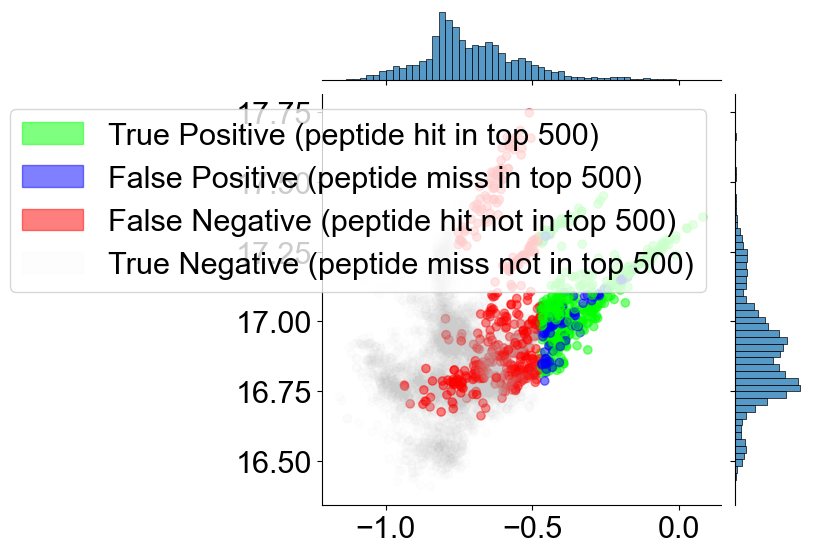

In [22]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)


(5547, 3)


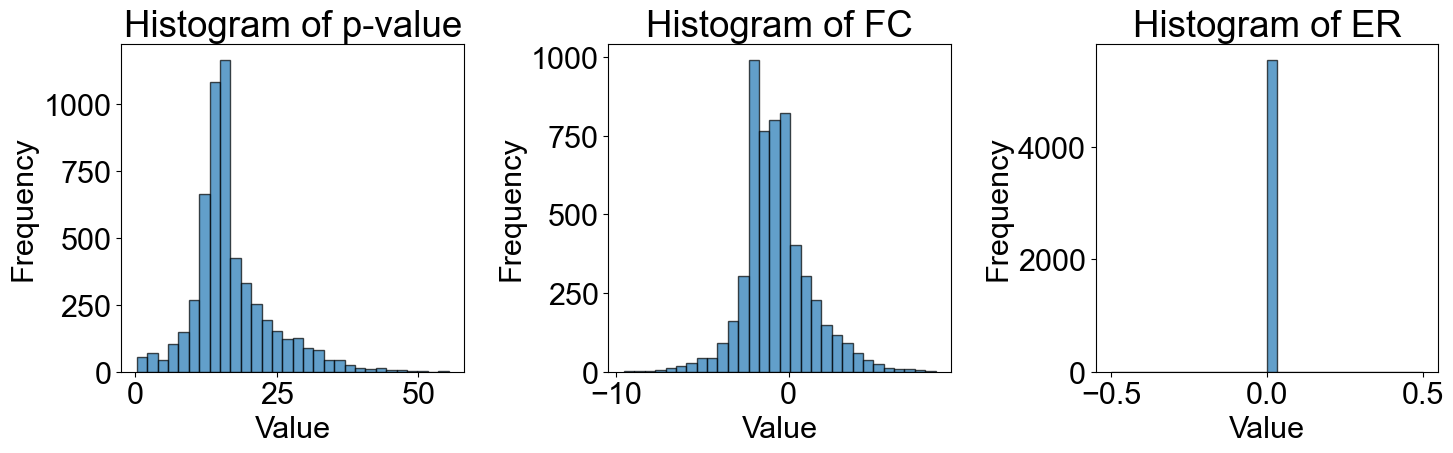

In [23]:
print(y_raw.shape)

# Convert y_raw to DataFrame if it's a NumPy array
if not isinstance(y_raw, pd.DataFrame):
    y_raw = pd.DataFrame(y_raw, columns=["p-value", "FC", "ER"])  # Assign custom column names

# Plot histograms for each column
fig, axes = plt.subplots(1, y_raw.shape[1], figsize=(15, 5))  # Create subplots

for i, column in enumerate(y_raw.columns):
    axes[i].hist(y_raw[column], bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

## Benchmark

In [24]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_SL_ordering, 'FC Ranking', '#56B4E9'
),
]

<Figure size 960x960 with 0 Axes>

In [25]:
### All future df_sorted is based on BiLSTM

print(len(peptides))
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])
df_unordered = pd.concat([df, df_flatX], axis=1)
df_sorted = df_unordered.sort_values(by="BiLSTM Ordering", ascending=False).reset_index(drop=True)
    
df_FC = pd.DataFrame(list(zip(peptides, fc_alone_SL_ordering)), columns=["Peptides", "FC Ordering"])
df_unordered_FC = pd.concat([df_FC, df_flatX], axis=1)
df_sorted_FC = df_unordered_FC.sort_values(by="FC Ordering", ascending=False).reset_index(drop=True)

# Print the first 10 rows
print(df_sorted.head(3))
print(df_unordered.head(3))

print(df_sorted_FC.head(10))

5547
  Peptides  BiLSTM Ordering  Pro2Vec_I1  Pro2Vec_I2  Pro2Vec_I3  Pro2Vec_I4  \
0  ADYKDDD         0.082184    0.617256    0.671953    0.595359    0.549553   
1  MGYKDDD         0.048995    0.617256    0.689672    0.605874    0.549553   
2  YKDDTDA         0.029006    0.617256    0.549553    0.621296    0.659633   

   Pro2Vec_I5  Pro2Vec_I6  Pro2Vec_I7    RAA_I1  ...  V_one_hot_I5  \
0    0.621296    0.799868    0.617256  0.192308  ...           0.0   
1    0.621296    0.799868    0.617256  0.833333  ...           0.0   
2    0.703295    0.704206    0.617256  0.698718  ...           0.0   

   V_one_hot_I6  V_one_hot_I7  X_one_hot_I1  X_one_hot_I2  X_one_hot_I3  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   

   X_one_hot_I4  X_one_hot_I5  X_one_hot_I6  X_one_hot_I7  
0           0.0           0.0       

# Create Fastas and Run Xstreme Motif Finder on BiLSTM results

In [36]:
### Makes fasta of top 1% according to BiLSTM model

# Define output file path
Top_Percent_fasta_BiLSTM = "BiLSTM_1percent.fasta"
Top_Percent_fasta_FC = "FC_1percent.fasta"
Whole_fasta = "Whole.fasta"

import random

expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}


amino_acids = list(expected_freqs.keys())
weights = list(expected_freqs.values())

def trim_sequence(s):
    if isinstance(s, str):
        if len(s) == 10 and s.startswith("AC"):
            return s[1:]
        elif len(s) == 9 and s.startswith("A"):
            return s[1:]
        elif len(s) == 7:
            rand_aa = random.choices(amino_acids, weights=weights, k=1)[0]
            return rand_aa + s
    return s

df_trimmed_BiLSTM = df_sorted.iloc[:, 0].astype(str).apply(trim_sequence).copy()
df_trimmed_unordered = df_unordered.iloc[:, 0].astype(str).apply(trim_sequence).copy()

_ = SL_Xstreme.makeFasta(Top_Percent_fasta_BiLSTM, df_trimmed_BiLSTM.iloc[0:150])

_ = SL_Xstreme.makeFasta(Whole_fasta, df_trimmed_unordered)


df_trimmed_FC = df_sorted_FC.iloc[:, 0].astype(str).apply(trim_sequence).copy()
_ = SL_Xstreme.makeFasta(Top_Percent_fasta_FC, df_trimmed_FC.iloc[0:150])


FASTA file saved as BiLSTM_1percent.fasta
FASTA file saved as Whole.fasta
FASTA file saved as FC_1percent.fasta


In [43]:
background_file_path = "xstreme_output/ShuffledBackground.txt"
bg_file = SL_Xstreme.create_protein_background(Whole_fasta, background_file_path)

✅ Background file written to: xstreme_output/ShuffledBackground.txt


In [44]:
# Run Xstreme
output_folder = "xstreme_output_BiLSTM"
minw = 3
maxw = 7

SL_Xstreme.run_xstreme_docker(Top_Percent_fasta_BiLSTM, output_folder, minw, maxw, background_file_path)

Running command:
 docker run -v /Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main:/data -w /data --rm memesuite/memesuite xstreme --protein --oc xstreme_output_BiLSTM --p BiLSTM_1percent.fasta --minw 3 --maxw 7 --bfile xstreme_output/ShuffledBackground.txt
Starting getsize: getsize BiLSTM_1percent.fasta 1> $metrics
GETSIZE ran successfully in 0.009475 seconds
Starting streme: streme --verbosity 1 --oc xstreme_output_BiLSTM/streme_out -protein --minw 3 --maxw 7 --order 0 --bfile xstreme_output_BiLSTM/ShuffledBackground.txt --seed 0 --align center --evalue --thresh 0.05 --p BiLSTM_1percent.fasta
STREME ran successfully in 0.16423 seconds
Starting meme: meme -oc xstreme_output_BiLSTM/meme_out -mod zoops -minw 3 -maxw 7 -bfile xstreme_output_BiLSTM/ShuffledBackground.txt -markov_order 0 -seed 0 -protein -evt 0.05 -nostatus BiLSTM_1percent.fasta
MEME ran successfully in 2.932899 seconds
Starting sea: sea --verbosity 1 --oc xstreme_output_BiLSTM/sea_out --qvalue 

In [45]:
# Run Xstreme
output_folder = "xstreme_output_FC"
minw = 3
maxw = 7

SL_Xstreme.run_xstreme_docker(Top_Percent_fasta_FC, output_folder, minw, maxw, background_file_path)


Running command:
 docker run -v /Users/stephen/Desktop/PythonPhastPep/2_29_24/RatmirData/ml_phage_display-main:/data -w /data --rm memesuite/memesuite xstreme --protein --oc xstreme_output_FC --p FC_1percent.fasta --minw 3 --maxw 7 --bfile xstreme_output/ShuffledBackground.txt
Starting getsize: getsize FC_1percent.fasta 1> $metrics
GETSIZE ran successfully in 0.009724 seconds
Starting streme: streme --verbosity 1 --oc xstreme_output_FC/streme_out -protein --minw 3 --maxw 7 --order 0 --bfile xstreme_output_FC/ShuffledBackground.txt --seed 0 --align center --evalue --thresh 0.05 --p FC_1percent.fasta
STREME ran successfully in 0.169063 seconds
Starting meme: meme -oc xstreme_output_FC/meme_out -mod zoops -minw 3 -maxw 7 -bfile xstreme_output_FC/ShuffledBackground.txt -markov_order 0 -seed 0 -protein -evt 0.05 -nostatus FC_1percent.fasta
MEME ran successfully in 3.203432 seconds
Starting sea: sea --verbosity 1 --oc xstreme_output_FC/sea_out --qvalue --thresh 1 --order 0 --bfile xstreme_ou

In [42]:
# 
streme_xml = "xstreme_output_BiLSTM/streme_out/streme.xml"
background_file = "xstreme_output/ShuffledBackground.txt"
peptide_fasta = "BiLSTM_1percent.fasta"
output_base_dir = "fimo_results_BiLSTM"

# ✅ Clear the top-level output directory if it exists
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
    print(f"🧹 Cleared existing directory: {output_base_dir}")


_ = SL_Xstreme.motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta)
motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta): 

🧹 Cleared existing directory: fimo_results_BiLSTM
  • 1-SYKDD: E-value = 4.1e-07
  • 2-SVQ: E-value = 4
  • 3-GQG: E-value = 4
  • 4-ALDD: E-value = 4
🔍 Running FIMO for motif: 1-SYKDD
✅ FIMO complete for motif 1-SYKDD. Results saved to 'fimo_results_BiLSTM/fimo_1-SYKDD/fimo.tsv'



In [ ]:

streme_xml = "xstreme_output_FC/streme_out/streme.xml"
background_file = "xstreme_output_FC/ShuffledBackground.txt"
peptide_fasta = "FC_1percent.fasta"
output_base_dir = "fimo_results_FC"

# ✅ Clear the top-level output directory if it exists
if os.path.exists(output_base_dir):
    shutil.rmtree(output_base_dir)
    print(f"🧹 Cleared existing directory: {output_base_dir}")


_ = SL_Xstreme.motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta)

In [ ]:
# Base directory containing FIMO result folders
fimo_base_dir = "fimo_results_FC"

# List to hold individual FIMO DataFrames
fimo_dfs = []

# Loop through FIMO subfolders and collect result tables
for folder in os.listdir(fimo_base_dir):
    subdir = os.path.join(fimo_base_dir, folder)
    fimo_file = os.path.join(subdir, "fimo.tsv")

    if os.path.isfile(fimo_file):
        df = pd.read_csv(fimo_file, sep='\t', comment='#')
        df['motif_source'] = folder  # Optional: add source info
        fimo_dfs.append(df)

# Assume `fimo_dfs` is your list of DataFrames
# Check that each DataFrame has the correct columns
required_columns = {'sequence_name', 'q-value', 'motif_source'}
for i, df in enumerate(fimo_dfs):
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns in dataframe {i}")
        
# Concatenate all DataFrames into one
fimo_combined_df = pd.concat(fimo_dfs, ignore_index=True)
# Optional: sort by q-value if you're interested in best hits
fimo_combined_df.sort_values(by='q-value', inplace=True)
    
# Start with all values set to NaN so we can identify sequences with no hits
FIMO_rank = np.full(df_sorted.shape[0], np.nan)

#fimo_combined_df.reset_index(drop=True, inplace=True)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].str.replace('seq_', '', regex=False).astype(int)

print(fimo_combined_df)


In [ ]:
# Step 1: Make sure sequence_name is int (already appears to be)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].astype(int)

# Step 2: Get the best (lowest) q-value per sequence_name (i.e., peptide index)
min_qvals = fimo_combined_df.groupby('sequence_name')['q-value'].min()

# Step 3: Initialize a Series with q=1 for all indices in df_sorted
fimo_rank = pd.Series(1.0, index=df_unordered.index)

# Step 4: Overwrite available indices with their actual q-values from FIMO
fimo_rank.update(min_qvals)

# Step 5: Optional: log-transform q-values for ranking (e.g., -log10)
# Replace 0s (if any) to avoid log errors
fimo_rank = -np.log10(fimo_rank.replace(0, np.nextafter(0, 1)))

# Step 6: Add FimoRank to df_sorted as the 3rd column
FimoDF = df_unordered_FC.copy()
FimoDF.insert(2, 'FimoRank', fimo_rank)

# Sort by FimoRank descending (i.e., best hits on top)
FimoDF = FimoDF.sort_values(by="FimoRank", ascending=False).reset_index(drop=True)

# Preview top 100
print(FimoDF.head(10))
print(fimo_rank)

In [ ]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_sorted["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_sorted["BiLSTM Ordering"] > -.466).sum()
print(f"Number of peptides with BiLSTM Ordering > -.466: {count}")


## Check PCA Variance

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:150, start_col:].copy()

print(df_numeric)
num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:, start_col:].copy()

num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
# PCA scores and Loadings for Top 1%
L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:150, start_col:].copy()
df_1_percent_peptides = df_sorted.iloc[0:150, 0].copy()

# Perform PCA
if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

pca = PCA(n_components=2)
pc_values = pca.fit_transform(df_numeric_1percent)
loadings = pca.components_.T  # Loadings matrix (shape: features × PCs)

# Create DataFrame for scores
df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
df_pca["Peptides"] = df_1_percent_peptides

# Create DataFrame for loadings
df_loadings = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=df_numeric_1percent.columns)

# ---- Plot PCA Scores (Scatterplot) ----
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

for i, row in df_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Scores: Peptides in PC1 vs PC2 Space")
plt.grid(True)
plt.show()

# ---- Plot PCA Loadings (Biplot Style) ----
plt.figure(figsize=(10, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x="PC1", y="PC2", data=df_loadings, alpha=0.7, color='red')

for i, row in df_loadings.iterrows():
    plt.text(row["PC1"], row["PC2"], row.name, fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Loadings: Variable Contributions to PCs")
plt.grid(True)
plt.show()

In [ ]:
##### PCA on top 1%

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:150, start_col:].copy()
print(df_numeric_1percent.shape)

if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

# Perform PCA, reducing to 70 principal components
pca = PCA(n_components=43)
pc_values = pca.fit_transform(df_numeric_1percent)

# Create a DataFrame with PC1 and PC2
df_pca = pd.DataFrame(pc_values)

print(df_pca.shape)


In [ ]:
# Evalueate Kmeans clustering on df_pca of top 1%
inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca, cluster_range=range(2, 20), method='kmeans')

In [ ]:
# Does Kmeans clustering on top 1% without PCA

L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_features = df_sorted.iloc[:150, start_col:].copy()

# Drop the first two columns (assuming they are non-numeric)
if L2norm: 
    df_features = normalize(df_features, norm="l2")  # L2 normalization
    
df_1_percent_peptides = df_sorted.iloc[:150, 0].copy()
print(df_1_percent_peptides.shape)

inertia, sil_scores = SL_PCA.evaluate_clustering(df_features, cluster_range=range(2, 20), method='kmeans')


In [ ]:
df_pca_kmed = df_pca.copy()

inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca_kmed, cluster_range=range(2, 20), method='kmedoids')

In [ ]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_pca)

# Make a new DataFrame that includes cluster labels
df_pca_with_cluster = df_pca.copy()
df_pca_with_cluster["K-means_Cluster"] = cluster_labels
print(df_pca_with_cluster.head(11))

In [ ]:
##### df_pca kmeans clustering

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = df_pca_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")
print(cluster_means_pca)

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
print('inverse_pca ',approx_one_hot_pca.shape)
approx_one_hot_pca = np.array(approx_one_hot_pca)

approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
# Perform K-means clustering with 3 clusters

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:150, 0].copy()

kmeans = KMeans(n_clusters=4, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_sorted.iloc[:150, start_col:].copy())

# Make a new DataFrame that includes cluster labels
df_with_cluster =  df_sorted.iloc[:150, start_col:].copy()
df_with_cluster["K-means_Cluster"] = cluster_labels
print(df_with_cluster.head())

In [ ]:
# Non-PCA

# Ensure 'Cluster' is included separately for grouping
cluster_means = df_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means)

approx_one_hot = np.array(cluster_means)


approx_one_hot_df = pd.DataFrame(approx_one_hot, index=cluster_means.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df.shape}")
print(approx_one_hot_df)

# Count the number of members in each cluster
print(df_with_cluster["K-means_Cluster"].value_counts())


approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
# Non-PCA skip

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()

df_1_p_features = df_sorted.iloc[:330, start_col:].copy()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)


# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_1_p_features)

# Make a new DataFrame that includes cluster labels
df_with_cluster = df_1_p_features.copy()

if L2norm: 
    df_with_clustersNorm = normalize(df_with_cluster, norm="l2")  # L2 normalization
    df_with_cluster["K-means_Cluster"] = kmeans.fit_predict(df_with_clusterNorm)
else:
# Perform K-means clustering with 3 clusters
    df_with_cluster["K-means_Cluster"] = kmeans.fit_predict(df_with_cluster)
    
print(df_with_cluster.head())

"""
kmedoids = KMedoids(n_clusters=6, metric='cosine', random_state=42)
df_1_p_features["Cluster"] = kmedoids.fit_predict(df_1_p_features)
print(df_1_p_features)
"""
# Save the results (optional)
#df_trimmed_one_hot.to_csv("peptides_clustered.csv", index=False)

#print("K-means clustering complete. Cluster labels added to 'peptides_clustered.csv'.")

In [ ]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_with_cluster.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")

Full_Trimmed_one_hot = df_unordered.iloc[:, 225:].copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["K-means_Cluster"].value_counts()

In [ ]:
# Convert to NumPy arrays
peptide_encodings = np.array(df_unordered.iloc[:, 226:]).copy()  

# Ensure cluster_means is a NumPy array
if isinstance(cluster_means, dict):
    raise TypeError("Error: 'cluster_means' is a dictionary. Convert it to a NumPy array or DataFrame.")
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        #"Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"K_means Normal": cluster_means_array, "K_means PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered.iloc[:,226:].copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

In [ ]:
###skip

# Create a copy to avoid modifying the original DataFrame
df_index = df_re_ranked.copy()
df_index_pca = df_re_ranked_pca.copy()
print(df_index_pca.head())

# Rank peptides by BiLSTM Ordering (highest BiLSTM Ordering = rank 1)
df_index['BiLSTM_Rank'] = df_index['BiLSTM Ordering'].rank(ascending=False, method='first')
df_index_pca['BiLSTM_Rank'] = df_index_pca['BiLSTM Ordering'].rank(ascending=False, method='first')

# Sort the entire DataFrame based on BiLSTM Rank
#df_index = df_index.sort_values(by='BiLSTM_Rank').reset_index(drop=True)

# Select first 500 peptides to plot (you can adjust this based on your needs)
df_plot = df_index.iloc[:500].copy()

# Plotting the comparison
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_plot['Max_Similarity_Score'], y=df_plot['BiLSTM_Rank'], alpha=0.7)

# Labels and title
plt.xlabel("Peptide Index by Similarity Score")
plt.ylabel("Peptide Index by BiLSTM Ordering")
plt.title("Peptide Index Comparison: Similarity Score vs BiLSTM Ordering (Top 500 Peptides)")
plt.grid(True)

# Show plot
plt.show()

print(df_index_pca.head())

In [ ]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

In [ ]:
from matplotlib.pyplot import figure

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings with fixed colors
rankings = [
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_SL_ordering, 'ER Ranking', '#D55E00'),
    (er_fc_joint_SL_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (fimo_rank, "XSTREME_Ranking", "#5757F9"),
    #(volcano_ordering, "Joint FC/Pval Ranking", "#5757F9"),
    (fc_alone_SL_ordering, 'FC Ranking', '#56B4E9')
]

# Generate distinct colors for K-means orderings dynamically
num_kmeans_metrics = len(KmeansSL_orderings)
color_palette = sns.color_palette("husl", num_kmeans_metrics)  # Using Husl for distinct colors

# Add K-means similarity orderings with unique colors
for (col_name, ordering_values), color in zip(KmeansSL_orderings.items(), color_palette):
    rankings.append((ordering_values, col_name, color))

# Check output
print("Number of Rankings:", len(rankings))

In [ ]:
plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_SL_motif if protein_of_interest =="SL" else seq_contains_12ca5_motif,
    save_file='SL_hit_rankings.csv' if protein_of_interest =='SL' else '12ca5_hit_rankings.csv',
)

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 100

print(y_raw.shape)
y_raw = np.array(y_raw)

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 2)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0=0")

In [ ]:
from utils.utils import seed_everything
seed_everything(0)
num_combinations = 200

# Generate random positive coefficients
coefficients = np.random.rand(num_combinations, 3)  
coefficients /= coefficients.sum(axis=1, keepdims=True)  # Normalize to sum to 1
#print("Generated coefficients:\n", coefficients)

optim_orderings = {}  # Store ranking results
auc_scores = []  # Store (AUC, weight) pairs

# Compute orderings for each coefficient set
for i, (w2, w1, w0) in enumerate(coefficients):
    optim_orderings[f"combination_{i}"] = [w2 * y[2] + w1 * y[1] + w0 * y[0] for y in y_raw] #w2=ER,w1=

# Iterate through all orderings and compute AUC
for i, (ranking_name, ordering) in enumerate(optim_orderings.items()):
    
    # Define the ranking structure
    rankings = [(ordering, ranking_name, '#0F980F')]

    # Compute AUC
    auc_value = plot_ratio_by_ranking(
        peptides=peptides,
        y_rankings=rankings,
        title="",
        peptide_dataset_size=top_k_size,
        hit_rate_func=seq_contains_mdm2_motif if protein_of_interest == "MDM2" else seq_contains_12ca5_motif,
        save_file='mdm2_hit_rankings.csv' if protein_of_interest == 'MDM2' else '12ca5_hit_rankings.csv',
    )
    
    # Store AUC with corresponding weights
    auc_scores.append((auc_value, coefficients[i]))

# Find the best AUC and corresponding weights
best_auc, best_weights = max(auc_scores, key=lambda x: x[0])

print(f"Best AUC: {best_auc:.4f}")
print(f"Best Weights: w2={best_weights[0]:.4f}, w1={best_weights[1]:.4f}, w0={best_weights[2]:.4f}")

# Now Hit Rate Benchmarking for 12ca5

In [ ]:
protein_of_interest = "12ca5"
other_protein = "MDM2"

def proxy_ranking_lambda(x):
    # Proxy metric is defined as FC (y_raw[:, 1]) + ER (y_raw[:, 2])
    return 1*x[1] + 1*x[2] + 0*x[0]

top_k_size = 500 if protein_of_interest == "MDM2" else 1000
motif_dectection_func = (
    seq_contains_mdm2_motif
    if protein_of_interest == "MDM2"
    else seq_contains_12ca5_motif
)
model_save_name = (
    "trained_models/final_models/mdm2_model.h5"
    if protein_of_interest == "MDM2"
    else "trained_models/final_models/12ca5_model.h5"
)


X, y_raw, peptides, FEATURE_LIST = data_loading.build_joint_dataset(
    er_datafile=f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
)


In [ ]:
volcano_ordering = (
    np.array([(val[0] + 6) * val[1] if val[1] > 0 else 0 for val in y_raw])
    if protein_of_interest == "MDM2"
    else np.array([val[0] * val[1] for val in y_raw])
)

fc_alone_mdm2_ordering = [y[1] for y in y_raw]

er_mdm2_ordering = [y[2] for y in y_raw]


er_fc_joint_mdm2_ordering = [y[2] + y[1] for y in y_raw]


In [ ]:
len(peptides)

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC Ranking", fc_alone_mdm2_ordering, 'Blues')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by FC + P-value Ranking", volcano_ordering, 'Purples')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER Ranking", er_mdm2_ordering, 'Oranges')
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by ER + FC Ranking", er_fc_joint_mdm2_ordering, 'Greens')

In [ ]:
cross_validation_results = experiment.Experiment().run_cross_validation_experiment(
    X=X,
    y=y_raw,
    model_architecture=partial(
        rnn.ThreeChannelRegressionRNN_gelu, loss=multi_channel_mse, width=64
    ),
    optimizer=partial(
        keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
    ),
    n_splits=10,
    load_trained_model=True,
    model_save_name=model_save_name,
    normalize=True,
    batch_size=128,
    num_epochs=5,
)


In [ ]:
bilstm_ordering, y_pred = benchmark_cross_validated_hit_rate(
    cross_validation_results=cross_validation_results,
    y_raw=y_raw,
    peptides=peptides,
    proxy_ranking_lambda=proxy_ranking_lambda,
    top_k_size=top_k_size,
    motif_dectection_func=motif_dectection_func,
)

In [ ]:
print(y_raw.shape)

# Convert y_raw to DataFrame if it's a NumPy array
if not isinstance(y_raw, pd.DataFrame):
    y_raw = pd.DataFrame(y_raw, columns=["p-value", "FC", "ER"])  # Assign custom column names

# Plot histograms for each column
fig, axes = plt.subplots(1, y_raw.shape[1], figsize=(15, 5))  # Create subplots

for i, column in enumerate(y_raw.columns):
    axes[i].hist(y_raw[column], bins=30, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

rankings=[
(
    bilstm_ordering, 'BiLSTM Model Ranking', '#F94040'
),
(
    er_mdm2_ordering, 'ER Ranking', '#D55E00'
),
(
    er_fc_joint_mdm2_ordering, 'Joint ER/FC Ranking', '#0F980F'
),
(
    volcano_ordering, 'Joint FC/Pval Ranking', '#5757F9'
),
(
    fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9'
),
]

In [ ]:
show_heatmap_for_top_k(f"Heatmap of Top {top_k_size} {protein_of_interest} Putative Binders by BiLSTM Ranking", bilstm_ordering, 'Reds')

In [ ]:
print(len(peptides))

print(X.shape)
print(len(FEATURE_LIST))
flatX = X.reshape(X.shape[0], -1)  # (785, 518)
print(flatX.shape)

# Expand feature names by appending _T1 to _T14
expanded_feature_names = [f"{feat}_I{t+1}" for feat in FEATURE_LIST for t in range(14)]

# Convert to DataFrame with correct column names
df_flatX = pd.DataFrame(flatX, columns=expanded_feature_names)

# Display the first few rows
df_flatX.head()

# Create a DataFrame
df = pd.DataFrame(list(zip(peptides, bilstm_ordering)), columns=["Peptides", "BiLSTM Ordering"])

df_unordered = pd.concat([df, df_flatX], axis=1)
df_sorted = df_unordered.sort_values(by="BiLSTM Ordering", ascending=False).reset_index(drop=True)

# Print the first 10 rows
print(df_sorted.head())
print(df_unordered.head())


In [ ]:
import pandas as pd
import random

# Optional: set seed for reproducibility
random.seed(42)

# Path to CSV file
csv_path = "data/12ca5-MDM2-R3.csv"

# Read CSV and extract the first two columns
df = pd.read_csv(csv_path)
df = df.iloc[:, :2]
df.columns = ["Number", "Peptide"]  # rename for clarity


# Expected amino acid frequencies
expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}
amino_acids = list(expected_freqs.keys())
weights = list(expected_freqs.values())

# Trimming logic for peptide sequences
def trim_sequence(s):
    if isinstance(s, str):
        if len(s) == 10 and s.startswith("AC"):
            return s[1:]
        elif len(s) == 9 and s.startswith("A"):
            return s[1:]
        elif len(s) == 7:
            rand_aa = random.choices(amino_acids, weights=weights, k=1)[0]
            return rand_aa + s
    return s

# Apply trimming to all sequences
df["Trimmed"] = df["Peptide"].astype(str).apply(trim_sequence)

print(df)


# Sort by score to get top 1%
top_1_percent = int(len(df) * 0.01)
df_top1 = df.iloc[:top_1_percent]

# Output FASTA file paths
Top_Percent_fasta = "SL_1percent.fasta"
All_fasta = "Whole.fasta"

# Write FASTA function
def write_fasta(filename, sequences):
    with open(filename, "w") as f:
        for i, seq in enumerate(sequences):
            f.write(f">seq_{i}\n{seq}\n")

# Write FASTA files
write_fasta(Top_Percent_fasta, df_top1["Trimmed"])
write_fasta(All_fasta, df["Trimmed"])

In [ ]:
### Makes fasta of top 1% according to BiLSTM model

import random

expected_freqs = {
    'A': 2/32, 'C': 1/32, 'D': 1/32, 'E': 1/32, 'F': 1/32,
    'G': 2/32, 'H': 1/32, 'I': 1/32, 'K': 1/32, 'L': 3/32,
    'M': 1/32, 'N': 1/32, 'P': 2/32, 'Q': 2/32, 'R': 3/32,
    'S': 3/32, 'T': 2/32, 'V': 2/32, 'W': 1/32, 'Y': 1/32
}


amino_acids = list(expected_freqs.keys())
weights = list(expected_freqs.values())

# Define output file path
Top_Percent_fasta = "12ca5_1percent.fasta"
All_fasta = "Whole.fasta"

def trim_sequence(s):
    if isinstance(s, str):
        if len(s) == 10 and s.startswith("AC"):
            return s[1:]
        elif len(s) == 9 and s.startswith("A"):
            return s[1:]
        elif len(s) == 7:
            rand_aa = random.choices(amino_acids, weights=weights, k=1)[0]
            return rand_aa + s
    return s

print(df_unordered.iloc[:,0])

df_trimmed_BiLSTM = df_sorted.iloc[:, 0].astype(str).apply(trim_sequence).copy()
df_trimmed_unordered = df_unordered.iloc[:, 0].astype(str).apply(trim_sequence).copy()

_ = SL_Xstreme.makeFasta(Top_Percent_fasta, df_trimmed_BiLSTM.iloc[0:454])

_ = SL_Xstreme.makeFasta(All_fasta, df_trimmed_unordered.iloc[0:])

In [ ]:
background_file_path = "xstreme_output/ShuffledBackground.txt"
bg_file = SL_Xstreme.create_protein_background(All_fasta, background_file_path)

In [ ]:
# Run Xstreme
temp_fasta = "SL_1percent.fasta"
background = "xstreme_output/ShuffledBackground.txt" #default is going to be either all equal or shuffled input
output_folder = "xstreme_output"
minw = 3
maxw = 6

SL_Xstreme.run_xstreme_docker(temp_fasta, output_folder, minw, maxw, background)

In [ ]:
# 
streme_xml = "xstreme_output/streme_out/streme.xml"
background_file = "xstreme_output/ShuffledBackground.txt"
peptide_fasta = "Whole.fasta"
output_base_dir = "fimo_results_all/SL"

_ = SL_Xstreme.motifFIMO(output_base_dir, streme_xml, background_file, peptide_fasta)

In [ ]:
# Base directory containing FIMO result folders
fimo_base_dir = "fimo_results_all/SL"

# List to hold individual FIMO DataFrames
fimo_dfs = []

# Loop through FIMO subfolders and collect result tables
for folder in os.listdir(fimo_base_dir):
    subdir = os.path.join(fimo_base_dir, folder)
    fimo_file = os.path.join(subdir, "fimo.tsv")

    if os.path.isfile(fimo_file):
        df = pd.read_csv(fimo_file, sep='\t', comment='#')
        df['motif_source'] = folder  # Optional: add source info
        fimo_dfs.append(df)

# Assume `fimo_dfs` is your list of DataFrames
# Check that each DataFrame has the correct columns
required_columns = {'sequence_name', 'q-value', 'motif_source'}
for i, df in enumerate(fimo_dfs):
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Missing required columns in dataframe {i}")
        
# Concatenate all DataFrames into one
fimo_combined_df = pd.concat(fimo_dfs, ignore_index=True)
# Optional: sort by q-value if you're interested in best hits
fimo_combined_df.sort_values(by='q-value', inplace=True)
    
# Start with all values set to NaN so we can identify sequences with no hits
FIMO_rank = np.full(df_sorted.shape[0], np.nan)

#fimo_combined_df.reset_index(drop=True, inplace=True)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].str.replace('seq_', '', regex=False).astype(int)

print(fimo_combined_df)


In [ ]:
# Step 1: Make sure sequence_name is int (already appears to be)
fimo_combined_df['sequence_name'] = fimo_combined_df['sequence_name'].astype(int)

# Step 2: Get the best (lowest) q-value per sequence_name (i.e., peptide index)
min_qvals = fimo_combined_df.groupby('sequence_name')['q-value'].min()

# Step 3: Initialize a Series with q=1 for all indices in df_sorted
fimo_rank = pd.Series(1.0, index=df_unordered.index)

# Step 4: Overwrite available indices with their actual q-values from FIMO
fimo_rank.update(min_qvals)

# Step 5: Optional: log-transform q-values for ranking (e.g., -log10)
# Replace 0s (if any) to avoid log errors
fimo_rank = -np.log10(fimo_rank.replace(0, np.nextafter(0, 1)))

# Step 6: Add FimoRank to df_sorted as the 3rd column
FimoDF = df_unordered.copy()
FimoDF.insert(2, 'FimoRank', fimo_rank)

# Sort by FimoRank descending (i.e., best hits on top)
FimoDF = FimoDF.sort_values(by="FimoRank", ascending=False).reset_index(drop=True)

# Preview top 100
print(FimoDF.head(100))
print(fimo_rank)

In [ ]:
# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(df_sorted["BiLSTM Ordering"], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("BiLSTM Ordering")
plt.ylabel("Frequency")
plt.title("Histogram of BiLSTM Ordering")

# Show plot
plt.show()

count = (df_sorted["BiLSTM Ordering"] > 3.874).sum()
print(f"Number of peptides with BiLSTM Ordering > 3.874: {count}")

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:330, start_col:].copy()

print(df_numeric)
num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
##### PCA clustering
start_col = df_sorted.columns.get_loc("A_one_hot_I1")
print(start_col)
df_numeric = df_sorted.iloc[:, start_col:].copy()

num_pc = SL_PCA.perform_pca_variance_analysis(df_numeric, L2norm=False)

In [ ]:
# PCA scores and Loadings for Top 1%
L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:330, start_col:].copy()
df_1_percent_peptides = df_sorted.iloc[0:330, 0].copy()

# Perform PCA
if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

pca = PCA(n_components=2)
pc_values = pca.fit_transform(df_numeric_1percent)
loadings = pca.components_.T  # Loadings matrix (shape: features × PCs)

# Create DataFrame for scores
df_pca = pd.DataFrame(pc_values, columns=["PC1", "PC2"])
df_pca["Peptides"] = df_1_percent_peptides

# Create DataFrame for loadings
df_loadings = pd.DataFrame(loadings, columns=["PC1", "PC2"], index=df_numeric_1percent.columns)

# ---- Plot PCA Scores (Scatterplot) ----
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", data=df_pca, alpha=0.7)

for i, row in df_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], row["Peptides"], fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Scores: Peptides in PC1 vs PC2 Space")
plt.grid(True)
plt.show()

# ---- Plot PCA Loadings (Biplot Style) ----
plt.figure(figsize=(10, 8))
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

sns.scatterplot(x="PC1", y="PC2", data=df_loadings, alpha=0.7, color='red')

for i, row in df_loadings.iterrows():
    plt.text(row["PC1"], row["PC2"], row.name, fontsize=8, ha="right", va="bottom")

plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.title("PCA Loadings: Variable Contributions to PCs")
plt.grid(True)
plt.show()

In [ ]:
##### PCA clustering

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_numeric_1percent = df_sorted.iloc[:330, start_col:].copy()
print(df_numeric_1percent.shape)

if L2norm: 
    df_numeric_1percent = normalize(df_numeric_1percent, norm="l2")  # L2 normalization

# Perform PCA, reducing to 62 principal components
pca = PCA(n_components=62)
pc_values = pca.fit_transform(df_numeric_1percent)

# Create a DataFrame with PC1 and PC2
df_pca = pd.DataFrame(pc_values)

print(df_pca.shape)


In [ ]:
# Evalueate Kmeans clustering on df_pca of top 1%
inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca, cluster_range=range(2, 20), method='kmeans')

In [ ]:
# Does Kmeans clustering on top 1% without PCA

L2norm = False

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_features = df_sorted.iloc[:330, start_col:].copy()

# Drop the first two columns (assuming they are non-numeric)
if L2norm: 
    df_features = normalize(df_features, norm="l2")  # L2 normalization
    
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()
print(df_1_percent_peptides.shape)

inertia, sil_scores = SL_PCA.evaluate_clustering(df_features, cluster_range=range(2, 20), method='kmeans')


In [ ]:
df_pca1 = df_pca.copy()

inertia, sil_scores = SL_PCA.evaluate_clustering(df_pca1, cluster_range=range(2, 20), method='kmedoids')

In [ ]:
# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_pca)

# Make a new DataFrame that includes cluster labels
df_pca_with_cluster = df_pca.copy()
df_pca_with_cluster["K-means_Cluster"] = cluster_labels
print(df_pca_with_cluster.head(11))

In [ ]:
##### df_pca kmeans clustering

# Ensure 'Cluster' is included separately for grouping
cluster_means_pca = df_pca_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means_pca.shape}")
print(cluster_means_pca)

# Inverse transform PCA-reduced cluster means back to approximate one-hot encoding
approx_one_hot_pca = pca.inverse_transform(cluster_means_pca)
print('inverse_pca ',approx_one_hot_pca.shape)
approx_one_hot_pca = np.array(approx_one_hot_pca)

approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
# Perform K-means clustering with 3 clusters

start_col = df_sorted.columns.get_loc("A_one_hot_I1")
df_1_percent_peptides = df_sorted.iloc[:330, 0].copy()

kmeans = KMeans(n_clusters=7, random_state=42, n_init=100)
cluster_labels = kmeans.fit_predict(df_sorted.iloc[:330, start_col:].copy())

# Make a new DataFrame that includes cluster labels
df_with_cluster =  df_sorted.iloc[:330, start_col:].copy()
df_with_cluster["K-means_Cluster"] = cluster_labels
print(df_with_cluster.head())

In [ ]:
# Non-PCA

# Ensure 'Cluster' is included separately for grouping
cluster_means = df_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means)

approx_one_hot = np.array(cluster_means)


approx_one_hot_df = pd.DataFrame(approx_one_hot, index=cluster_means.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df.shape}")
print(approx_one_hot_df)

# Count the number of members in each cluster
print(df_with_cluster["K-means_Cluster"].value_counts())


approx_one_hot_df_pca = pd.DataFrame(approx_one_hot_pca, index=cluster_means_pca.index)
print(f"Shape of approximated one-hot encoding: {approx_one_hot_df_pca.shape}")
print(approx_one_hot_df_pca)

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = approx_one_hot_df_pca.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot[i * num_amino_acids : (i + 1) * num_amino_acids]
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Apply one-hot_to_sequence to each cluster row
average_sequences_pca = {cluster: one_hot_to_sequence(approx_one_hot_df_pca.loc[cluster].values) 
                     for cluster in cluster_means_pca.index}

cluster_mean_AA_pca = average_sequences_pca
print('Cluster_means_pca ',cluster_mean_AA_pca)

# Print the average peptide sequences for each cluster
for cluster, avg_seq in average_sequences_pca.items():
    print(f"Cluster {cluster}: {avg_seq}")

# Count the number of members in each cluster
print(df_pca_with_cluster["K-means_Cluster"].value_counts())

In [ ]:
#Non-PCA

# Get only one-hot encoding columns (excluding first two cols and 'Cluster')
Top_1_with_cluster = df_with_cluster.copy()
print(f"Shape of Top_1_with_cluster: {Top_1_with_cluster.shape}")

Full_Trimmed_one_hot = df_unordered.iloc[:, 225:].copy()
print(f"Shape of Full_Trimmed_one_hot: {Full_Trimmed_one_hot.shape}")

# Ensure 'Cluster' is included separately for grouping
cluster_means = Top_1_with_cluster.groupby("K-means_Cluster").mean()  # Compute mean one-hot encoding
print(f"Shape of cluster_means: {cluster_means.shape}")
print(cluster_means.head(5))

# Define amino acids and peptide sequence length
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
num_amino_acids = len(amino_acids)
seq_length = cluster_means.shape[1] // num_amino_acids  # Determine peptide length
print(f"Determined sequence length: {seq_length}")

def one_hot_to_sequence(mean_one_hot):
    """Convert mean one-hot encoding back to an approximate peptide sequence."""
    sequence = []
    for i in range(seq_length):
        # Extract one-hot encoding for this position
        pos_one_hot = mean_one_hot.iloc[i * num_amino_acids : (i + 1) * num_amino_acids].values
        
        # Check if the one-hot encoding is correctly structured
        if len(pos_one_hot) != num_amino_acids:
            print(f"Warning: Unexpected length at position {i}: {len(pos_one_hot)}")
            continue
        
        # Get the most probable amino acid
        most_likely_aa = amino_acids[np.argmax(pos_one_hot)]  
        sequence.append(most_likely_aa)
    
    return "".join(sequence)

# Generate average peptide sequence for each cluster
average_sequences = cluster_means.apply(one_hot_to_sequence, axis=1)

# Print the average peptide sequences
for cluster, avg_seq in zip(cluster_means.index, average_sequences):
    print(f"Cluster {cluster}: {avg_seq}")
    
Top_1_with_cluster["K-means_Cluster"].value_counts()

In [ ]:
# Convert to NumPy arrays
peptide_encodings = np.array(df_unordered.iloc[:, 226:]).copy()  

# Ensure cluster_means is a NumPy array
if isinstance(cluster_means, dict):
    raise TypeError("Error: 'cluster_means' is a dictionary. Convert it to a NumPy array or DataFrame.")
cluster_means_array = np.array(cluster_means)
cluster_means_array_pca = np.array(approx_one_hot_pca) 

# Function to compute Pearson correlation efficiently
def compute_pearson_matrix(peptides, clusters):
    return np.array([[pearsonr(peptide, cluster)[0] for cluster in clusters] for peptide in peptides])

# Function to compute similarity metrics
def compute_similarity_metrics(peptides, clusters):
    return {
        #"Pearson": compute_pearson_matrix(peptides, clusters),
        "Cosine": cosine_similarity(peptides, clusters),
        "Euclidean": -cdist(peptides, clusters, metric='euclidean')  # Negative for similarity convention
    }

# Compute similarities for both normal and PCA cluster means
similarity_results = {metric: compute_similarity_metrics(peptide_encodings, clusters)
                      for metric, clusters in {"K_means Normal": cluster_means_array, "K_means PCA": cluster_means_array_pca}.items()}

# Convert similarity scores to DataFrames
df_similarity = {}
for metric, results in similarity_results.items():
    for sim_type, scores in results.items():
        df_similarity[f"{sim_type}_{metric}"] = pd.DataFrame(scores, 
            columns=[f"Similarity_to_Cluster_{i}" for i in range(scores.shape[1])])

# Create DataFrame for best similarity scores and their corresponding clusters
df_re_ranked = df_unordered.iloc[:,226:].copy()

for key, df in df_similarity.items():
    df_re_ranked[f"Max_{key}"] = df.max(axis=1)  # Highest similarity score
    df_re_ranked[f"Best_{key}_Cluster"] = df.idxmax(axis=1)  # Best-matching cluster

# Print top-ranked peptides
print(df_re_ranked.head())

In [ ]:
# Create copies of the original DataFrames
df_resorted = df_re_ranked.copy()

# Extract all similarity score columns dynamically
similarity_columns = [col for col in df_resorted.columns if "Max" in col]

# Dictionary to store K-means ordering values
KmeansSL_orderings = {col: df_resorted[col].values for col in similarity_columns}

# Print keys to verify
print("K-means Orderings:", KmeansSL_orderings.keys())

In [ ]:
from matplotlib.pyplot import figure

# Set figure size and DPI
figure(figsize=(12, 12), dpi=80)

# Define static rankings with fixed colors
rankings = [
    (bilstm_ordering, "BiLSTM Model Ranking", "#F94040"),
    (er_mdm2_ordering, 'ER Ranking', '#D55E00'),
    (er_fc_joint_mdm2_ordering, "Joint ER/FC Ranking", "#0F980F"),
    (fimo_rank, "XSTREME_Ranking", "#5757F9"),
    #(volcano_ordering, "Joint FC/Pval Ranking", "#5757F9"),
    (fc_alone_mdm2_ordering, 'FC Ranking', '#56B4E9')
]

# Generate distinct colors for K-means orderings dynamically
num_kmeans_metrics = len(KmeansSL_orderings)
color_palette = sns.color_palette("husl", num_kmeans_metrics)  # Using Husl for distinct colors

# Add K-means similarity orderings with unique colors
for (col_name, ordering_values), color in zip(KmeansSL_orderings.items(), color_palette):
    rankings.append((ordering_values, col_name, color))

# Check output
print("Number of Rankings:", len(rankings))

In [ ]:
protein_of_interest = "12ca5"
from matplotlib.pyplot import figure
figure(figsize=(12, 12), dpi=80)

plot_ratio_by_ranking(
    peptides=peptides,
    y_rankings=rankings,
    title="",
    peptide_dataset_size=top_k_size,
    hit_rate_func=seq_contains_mdm2_motif if protein_of_interest =="MDM2" else seq_contains_12ca5_motif,
    save_file='mdm2_hit_rankings.csv' if protein_of_interest =='MDM2' else '12ca5_hit_rankings.csv',
)